In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import re
import numba

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from tqdm.notebook import tqdm


# MLP for the Coupling layers

In [2]:
class MLP(nn.Module):
    """
    Multi-layer perceptron (MLP) to be obtain parameters of Coupling layers
    
    Parameters
    ----------
    n_input : int 
        Number of input neurons, depend on the dimensions of the input data. 
    n_output : int 
        Number of output neurons, depend on the number of parameters needed for the Coupling layers.
    n_hidden : int
        Number of hidden neurons in each layer.
    n_layers : int
        Number of layers in the network.
    neg_slope : float
        Negative slope for the leaky ReLU activation function.
    
    Returns
    -------
    None
    """

    def __init__(self, n_input, n_output, n_hidden, n_layers=4, neg_slope=0.2) -> None:
        super().__init__()
        ins = torch.ones(n_layers)*n_hidden
        ins[0] = n_input
        outs = torch.ones(n_layers)*n_hidden
        outs[-1] = n_output
        Lin_layers = list(map(nn.Linear, ins.type(torch.int), outs.type(torch.int)))
        ReLu_layers = [nn.LeakyReLU(neg_slope) for _ in range(n_layers)]
        self.network = nn.Sequential(*itertools.chain(*zip(Lin_layers, ReLu_layers)))
        # self.network.apply(init_weights)
    
    def forward(self, x):
        x.float()
        return self.network(x)

    # def init_weights(m):
    #     if isinstance(m, nn.Linear):
    #         torch.nn.kaiming_uniform_(m.weight, a=0, mode='fan_out', nonlinearity='leaky_relu', generator=None)
    #         m.bias.data.fill_(0.01)

In [3]:
net = MLP(3, 2, 16)
for param in net.parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


# GLOW_conv
permutate the input dimensions 

In [4]:
class GLOW_conv(nn.Module):
    def __init__(self, n_dim) -> None:
        super().__init__()
        self.n_dim = n_dim

        #Initialize W as orthogonal matrix and decompose it into P, L, U, the learned parameters
        W_initialize = nn.init.orthogonal_(torch.randn(self.n_dim, self.n_dim))
        P, L_, U_ = torch.linalg.lu(W_initialize)

        #P not changed (no grad) but it needs to be stored in the state_dict
        self.register_buffer("P", P)

        # Declare as model parameters
        #Diagonal of U sourced out to S
        S_ = torch.diagonal(U_)
        self.S = nn.Parameter(S_)
        self.L = nn.Parameter(L_)
        #Declare with diagonal 0s, without changing U_ and thus S_
        self.U = nn.Parameter(torch.triu(U_, diagonal=1))

    def _get_W_and_logdet(self):
        #Make sure the pieces stay in correct shape as in GLOW
        L = torch.tril(self.L, diagonal=-1) + torch.diag(torch.ones(self.n_dim).to(self.L.device))
        U = torch.triu(self.U, diagonal=1)
        S = torch.diag(self.S)
        
        W = self.P@L@(U+S)
        logdetW = torch.sum(torch.log(torch.abs(self.S)))

        return W, logdetW  
    
    # Pass condition as extra argument, that is not used in the convolution
    #it stayes untouched, does not get permuted with values that
    #will be transformed
    def forward(self, x, x_condition):
        W, logdetW = self._get_W_and_logdet()
        y = x.float()@W
        return y, logdetW
    
    def backward(self, y, x_condition):
        W, logdetW_inv = self._get_W_and_logdet()
        #Just a minus needed
        logdetW_inv = -logdetW_inv
        W_inv = torch.linalg.inv(W)
        x = y.float()@W_inv
        return x, logdetW_inv

# Affine Coupling layer

In [5]:
class AffineCoupling(nn.Module):
    """
    Affine Coupling layer for conditional normalizing flows.

    Args:
        dim_notcond (int): Dimension of the input not conditioned part.
        dim_cond (int): Dimension of the input conditioned part.
        network (nn.Module): Network architecture to use for the affine coupling layer.
        network_args (tuple): Additional arguments to pass to the network architecture.

    Attributes:
        dim_notcond (int): Dimension of the input not conditioned part.
        dim_cond (int): Dimension of the input conditioned part.
        net_notcond (nn.Module): Network for the not conditioned part.
        net_cond (nn.Module): Network for the conditioned part.
    """

    def __init__(self, dim_notcond, dim_cond, network=MLP, network_args=(16, 4, 0.2)):
        super().__init__()
        self.dim_notcond = dim_notcond
        self.dim_cond = dim_cond
        self.net_notcond = network(int(self.dim_notcond / 2), int(self.dim_notcond), *network_args)
        self.net_cond = network(self.dim_cond, int(self.dim_notcond), *network_args)

    def forward(self, x, x_condition):
        """
        Forward pass of the affine coupling layer.

        Args:
            x (torch.Tensor): Input tensor.
            x_condition (torch.Tensor): Condition tensor.

        Returns:
            torch.Tensor: Output tensor after applying the affine coupling layer.
            torch.Tensor: Log determinant of the Jacobian.
        """
        x_a, x_b = x.chunk(2, dim=1)
        log_s, t = (self.net_notcond(x_b) * self.net_cond(x_condition)).chunk(2, dim=1)
        # s = torch.exp(log_s)
        s = F.sigmoid(log_s)
        y_a = s * x_a + t
        y_b = x_b

        logdet = torch.sum(torch.log(s))

        return torch.cat([y_a, y_b], dim=1), logdet

    def backward(self, y, x_condition):
        """
        Backward pass of the affine coupling layer.

        Args:
            y (torch.Tensor): Input tensor.
            x_condition (torch.Tensor): Condition tensor.

        Returns:
            torch.Tensor: Output tensor.
            torch.Tensor: Log determinant of the Jacobian.
        """
        y_a, y_b = y.chunk(2, dim=1)
        log_s, t = (self.net_notcond(y_b) * self.net_cond(x_condition)).chunk(2, dim=1)
        # s = torch.exp(log_s)
        s = F.sigmoid(log_s)
        x_a = (y_a - t) / s
        x_b = y_b

        logdet = torch.sum(torch.log(s))

        return torch.cat([x_a, x_b], dim=1), logdet

In [6]:
x = torch.tensor([[1.,2.], [1.,2.]])
affine = AffineCoupling(2, 4)
glow_conv  = GLOW_conv(2)
for i in range(100):
    x, logdet = glow_conv.forward(x = x, x_condition=torch.tensor([1.,2., 3., 4.]))
    # x, logdet = affine.forward(x = x, x_condition=torch.tensor([1.,2.,3.,4.]))
    x



# Normalizing Flow

In [7]:
class NF_condGLOW(nn.Module):
    """Normalizing flow GLOW model with Affine coupling layers. Alternates coupling layers with GLOW convolutions Combines coupling layers and convolution layers."""

    def __init__(self, n_layers, dim_notcond, dim_cond, CL=AffineCoupling, **kwargs_CL):
        """
        Constructs a Normalizing flow model.

        Parameters
        ----------

        n_layers : int
            The number of flow layers. Flow layers consist of a coupling layer and a convolution layer.
        dim_notcond : int
            The dimension of the input, i.e. the dimension of the data that will be transformed.
        dim_cond : int
            The dimension of the condition. If 0, the coupling layer is not conditioned.
        CL : nn.Module
            The coupling layer to use. Affine coupling layers is the only available for now
        **kwargs_CL : dict
            The arguments for the coupling layer.
        """
        super().__init__()
        self.dim_notcond = dim_notcond
        self.dim_cond = dim_cond

        coupling_layers = [CL(dim_notcond, dim_cond, **kwargs_CL) for _ in range(n_layers)]
        conv_layers = [GLOW_conv(dim_notcond) for _ in range(n_layers)]


        self.layers = nn.ModuleList(itertools.chain(*zip(conv_layers,coupling_layers)))
        
        self.prior = torch.distributions.Normal(torch.zeros(dim_notcond), torch.ones(dim_notcond), validate_args=False)

        #Information about hyperparameters accessible from outside
        #The function _get_right_hypers below will then reconstruct this back to __init__ arguments, if you change the model, change both.
        #This is needed in the background for recreating the same model in some cases like sampling with multiprocessing
        kwargs_parsed = kwargs_CL.copy()
        kwargs_parsed["network"] = "MLP"
        self.give_kwargs = {"n_layers":n_layers, "dim_notcond":dim_notcond, "dim_cond":dim_cond, "CL":"AffineCoupling", **kwargs_parsed}
        
    def forward(self, x, x_cond):
        logdet = torch.zeros(x.shape[0]).to(x.device)
        
        for layer in self.layers:
            x, logdet_temp = layer.forward(x, x_cond)
            logdet += logdet_temp
            
        #Get p_z(f(x)) which is needed for loss function together with logdet
        prior_z_logprob = self.prior.log_prob(x).sum(-1)
        
        return x, logdet, prior_z_logprob
    
    def backward(self, y, x_cond):
        logdet = torch.zeros(y.shape[0]).to(y.device)
        
        for layer in reversed(self.layers):
            y, logdet_temp = layer.backward(y, x_cond)
            logdet += logdet_temp
            
        return y, logdet
    
    def sample_Flow(self, number, x_cond):
        """Samples from the prior and transforms the samples with the flow.
        
        Parameters
        ----------
        
        number : int
            The number of samples to draw. If a condition is given, the number of samples must be the same as the length of conditions.
        x_cond : torch.Tensor
            The condition for the samples. If dim_cond=0 enter torch.Tensor([]).
        """
        return self.backward(self.prior.sample(torch.Size((number,))), x_cond)[0]
    
    def to(self, device):
        #Modified to also move the prior to the right device
        super().to(device)
        self.prior = torch.distributions.Normal(torch.zeros(self.dim_cond).to(device), torch.ones(self.dim_cond).to(device))
        return self

In [8]:
Flow = NF_condGLOW(4, 2, 4)

x, logdet, prior_z_logprob = Flow(x=torch.tensor([[1.,2.], [3., 6.]]), x_cond=torch.tensor([1.,2.,3.,4.]))

print(x, '\n', logdet,'\n', prior_z_logprob)

tensor([[-0.1266,  0.6418],
        [-0.3988,  1.9229]], grad_fn=<CatBackward0>) 
 tensor([-5.5441, -5.5441], grad_fn=<AddBackward0>) 
 tensor([-2.0519, -3.7661], grad_fn=<SumBackward1>)


# Training the Conditional Glow model 

In [9]:
def training_flow(flow:NF_condGLOW, data:pd.DataFrame, cond_names:list,  epochs, lr=2*10**-2, batch_size=1024, loss_saver=None, checkpoint_dir=None, gamma=0.998, optimizer_obj=None):
    
    #Device the model is on
    device = flow.parameters().__next__().device

    #Infos to printout
    n_steps = data.shape[0]*epochs//batch_size+1

    #Get index based masks for conditional variables
    mask_cond = np.isin(data.columns.to_list(), cond_names)
    mask_cond = torch.from_numpy(mask_cond).to(device)

    # Convert DataFrame to tensor (index based)
    data = torch.from_numpy(data.values).type(torch.float)

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

    if optimizer_obj is None:
        optimizer = optim.Adam(flow.parameters(), lr=lr)
    else:
        optimizer = optimizer_obj

    lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

    #Save losses
    losses = []

    #Total number of steps
    ct = 0
    #Total number of checkpoints
    cp = 0

    start_time = time.perf_counter()

    for e in tqdm(range(epochs)):
        for i, batch in enumerate(data_loader):
            x = batch.to(device)
            
            #Evaluate model
            z, logdet, prior_z_logprob = flow(x[...,~mask_cond], x[...,mask_cond])
            # print(prior_z_logprob)
            if prior_z_logprob.isnan().any():
                break
            #Get loss
            loss = -torch.mean(logdet+prior_z_logprob) 
            losses.append(loss.item())
            
            #Set gradients to zero
            optimizer.zero_grad()
            #Compute gradients
            loss.backward()
            #Update parameters
            optimizer.step()
        
        ct += 1


        #Decrease learning rate every 10 steps until it is smaller than 3*10**-6, then every 120 steps
        if lr_schedule.get_last_lr()[0] <= 3*10**-6:
            decrease_step = 120
        else:
            decrease_step = 10

        #Update learning rate every decrease_step steps
        if ct % decrease_step == 0:
            lr_schedule.step()


## Test on toy set ([x, y], x~Norm, y~Uniform)

In [11]:
components = ["A", "B", "C"]
conditions = ["C"]

n=100000
dim_notcond = len(components)-len(conditions)
dim_cond = len(conditions)
data = np.random.normal(size=(n, len(components)))
data[:, 1] = np.random.uniform(-1, 1, n)
data[:, 2] = np.ones(n)
data = pd.DataFrame(data, columns=components)

flow = NF_condGLOW(n_layers=8, dim_notcond=dim_notcond, dim_cond=dim_cond)
losses = []
training_flow(flow = flow, 
              data = data, 
              cond_names=conditions, 
              epochs=100, lr=2*10**-2, batch_size=1024, 
              loss_saver=None, checkpoint_dir=None, gamma=0.998, optimizer_obj=None)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

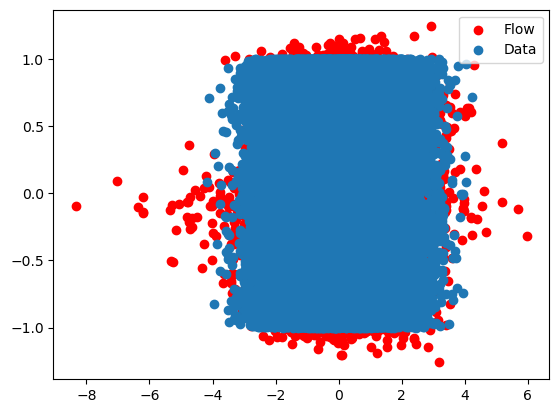

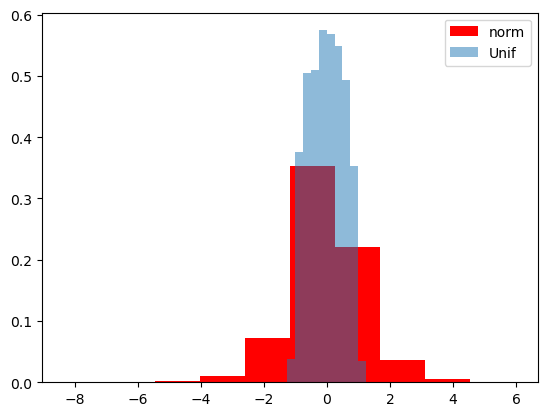

In [ ]:
n = 10000
output = flow.sample_Flow(n, torch.ones(n, len(conditions)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(output[:,0].detach().numpy(), output[:,1].detach().numpy(), c='r', label='Flow')
ax.scatter(data['A'], data['B'], label='Data')
ax.legend()

plt.show()
plt.hist(output[:,0].detach().numpy(), color='red', density=True, label='norm')
plt.hist(output[:,1].detach().numpy(), alpha=0.5, density=True, label='Unif')
plt.legend()

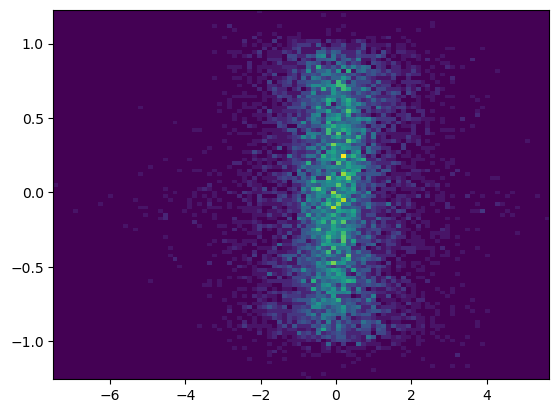

In [ ]:
n = 10000
output = flow.sample_Flow(n, torch.ones(n, len(conditions)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist2d(output[:,0].detach().numpy(), output[:,1].detach().numpy(), bins=(100, 100));

## Test on true data 

In [10]:
path_2parameters = sorted(os.listdir('../../data/parameters/'))
path_2observables = sorted(os.listdir('../../data/observables/'))

# Filter the lists of paths to take only the ones that don't have the word 'error' in them and 1024 snapshots
# regex = r'^(?!.*error).*1024.*$'
regex = r'^(?!.*error)'

path_2parameters = ['../../data/parameters/'+path for path in path_2parameters if re.search(regex, path)]
path_2observables = ['../../data/observables/'+path for path in path_2observables if re.search(regex, path)]

In [11]:
print('number of observables', np.load(path_2observables[0])['feh'].shape)
# print('number of parameters', np.log10(np.load('../../data/parameters/'+path_2parameters[0])['gas_mass']))

number of observables (19,)


In [12]:
def normalize(df):
    return df.apply(lambda x: (x.to_numpy() - x.to_numpy().mean()) / x.to_numpy().std(), axis=0)


def load_data(observables_paths):
    len_array = 0
    for observables_path in observables_paths:
        feh = np.load(observables_path)['feh']
        feh = feh[feh > -5]
        len_array += len(feh)

    name_columns_observables = [i for i in np.load(observables_paths[0]).keys()]
    name_coumns_parameters = [i for i in np.load(observables_paths[0].replace('observables', 'parameters')).keys()][:-2]
    name_columns_mean_std = ['mean_metallicity', 'mean_FeMassFrac', 'mean_OMassFrac', 'std_metallicity', 'std_FeMassFrac', 'std_OMassFrac']
    components = name_columns_observables + name_coumns_parameters + name_columns_mean_std  

    data = np.zeros(shape=(len_array, len(components)))
    i=0
    for observables_path in observables_paths:
        observables = np.load(observables_path)
        parameters = np.load(observables_path.replace('observables', 'parameters'))
        l = len(observables['feh'][observables['feh']>-5])
        data[i:i+l, 0] = observables['feh'][observables['feh']>-5]
        data[i:i+l, 1] = observables['ofe'][observables['feh']>-5]
        ones = np.ones(l)
        data[i:i+l, 2] = np.log10(parameters['star_mass'])*ones
        data[i:i+l, 3] = np.log10(parameters['gas_mass'])*ones
        data[i:i+l, 4] = np.log10(parameters['dm_mass'])*ones
        data[i:i+l, 5] = np.log10(parameters['infall_time'])*ones
        data[i:i+l, 6] = parameters['redshift']*ones
        data[i:i+l, 7] = parameters['a']*ones
        data[i:i+l, 8] = parameters['chemical_mean'][0]*ones
        data[i:i+l, 9] = parameters['chemical_mean'][1]*ones
        data[i:i+l, 10] = parameters['chemical_mean'][2]*ones
        data[i:i+l, 11] = parameters['chemical_std'][0]*ones
        data[i:i+l, 12] = parameters['chemical_std'][1]*ones
        data[i:i+l, 13] = parameters['chemical_std'][2]*ones
        i=i+l

    df = pd.DataFrame(data, columns=components)
    return normalize(df)   

In [13]:
a = load_data(path_2observables)
a.head()

,feh,ofe,star_mass,gas_mass,dm_mass,infall_time,redshift,a,mean_metallicity,mean_FeMassFrac,mean_OMassFrac,std_metallicity,std_FeMassFrac,std_OMassFrac
0,-4.548592,4.663849,-5.532432,-1.53152,0.123854,-8.103683,19.014243,-3.575932,-1.435334,-1.379121,-1.437629,-1.593552,-1.416036,-1.602028
1,-4.642690,4.259650,-5.532432,-1.53152,0.123854,-8.103683,19.014243,-3.575932,-1.435334,-1.379121,-1.437629,-1.593552,-1.416036,-1.602028
2,-3.897883,4.007094,-5.532432,-1.53152,0.123854,-8.103683,19.014243,-3.575932,-1.435334,-1.379121,-1.437629,-1.593552,-1.416036,-1.602028
3,-4.317403,3.979937,-5.532432,-1.53152,0.123854,-8.103683,19.014243,-3.575932,-1.435334,-1.379121,-1.437629,-1.593552,-1.416036,-1.602028
4,-3.446843,-1.778055,-5.532432,-1.53152,0.123854,-8.103683,19.014243,-3.575932,-1.435334,-1.379121,-1.437629,-1.593552,-1.416036,-1.602028


In [15]:
np.save('../../data/training_set/normalized_training_set.npy', a.values)

In [20]:
for i in range(len(a.keys())):
    print(i, a.values[:,i].mean(), a.values[:,i].std())


0 -2.7261277397828017e-15 1.000000000000004
1 1.2513456676866403e-16 1.000000000000014
2 -9.93197341770714e-13 0.9999999999999999
3 -2.7869051530870642e-12 0.9999999999999932
4 3.2453196360601955e-11 0.9999999999998976
5 1.2463925060280271e-12 0.9999999999998297
6 1.2262259855808775e-13 1.0000000000002622
7 -1.1679798407240493e-12 1.0000000000001308
8 9.628588025186093e-14 1.0000000000001548
9 -1.0246352542321852e-14 1.00000000000001
10 9.234546943211823e-15 1.0000000000000604
11 -4.009313883658003e-13 0.9999999999999215
12 -1.7917947348347254e-14 1.0000000000000335
13 1.2866564385901241e-14 0.9999999999999457


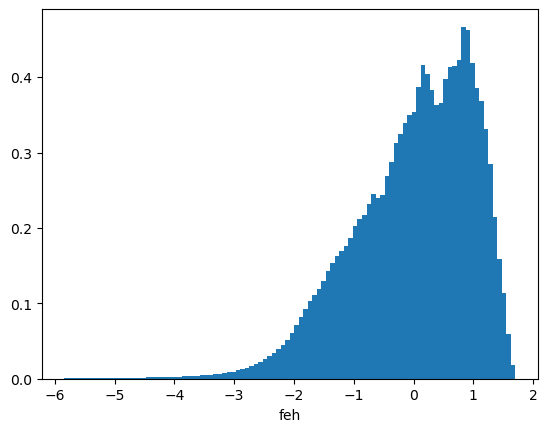

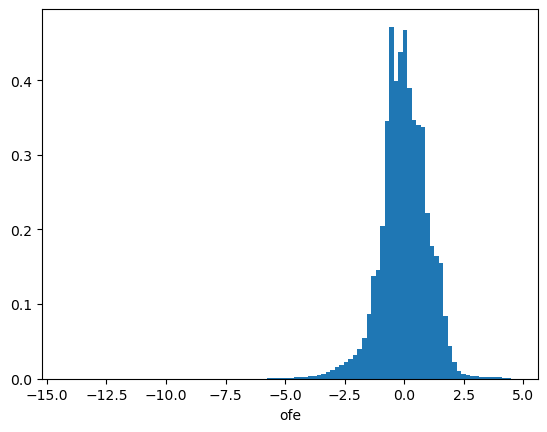

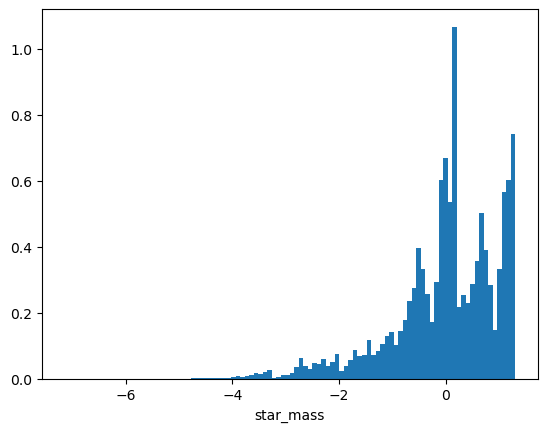

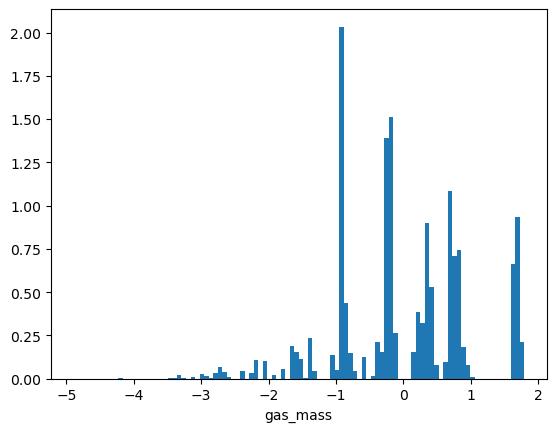

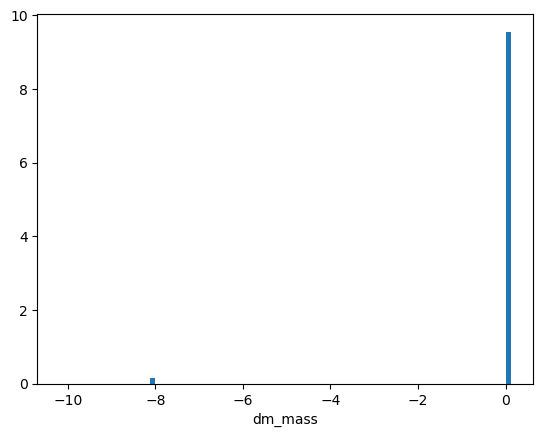

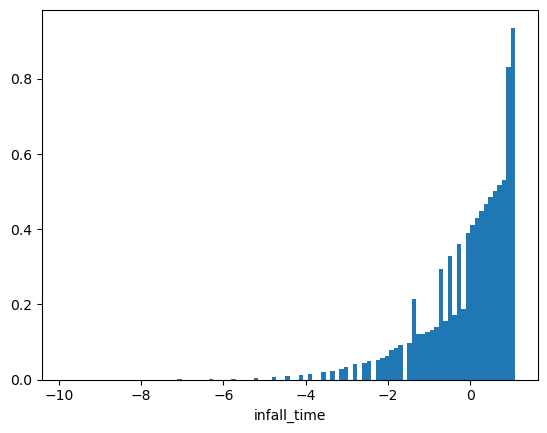

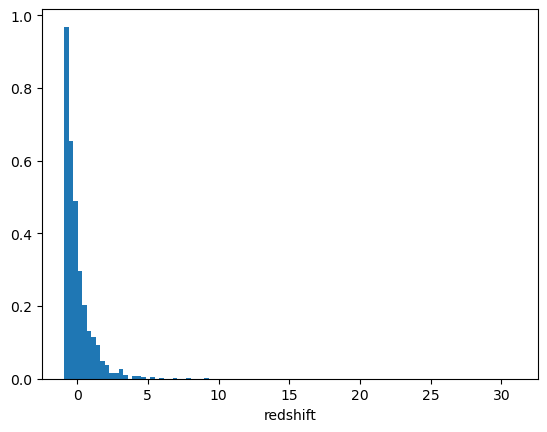

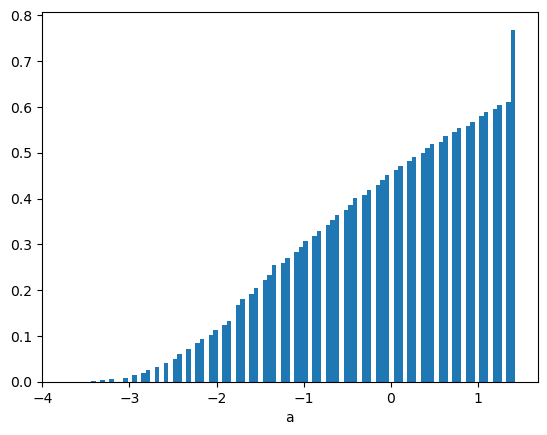

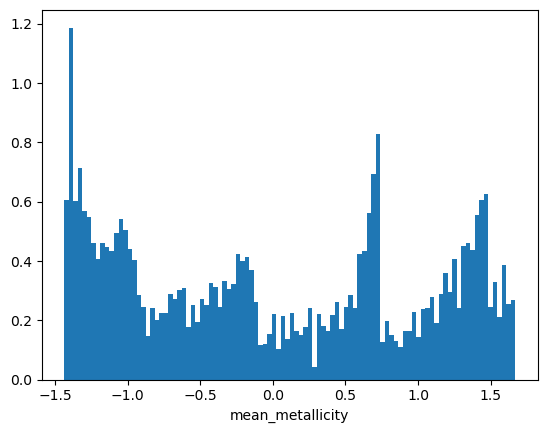

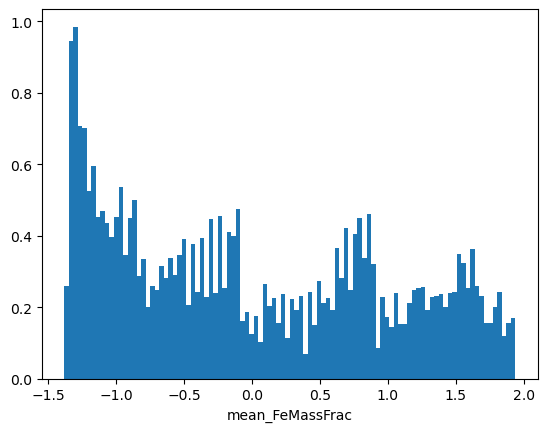

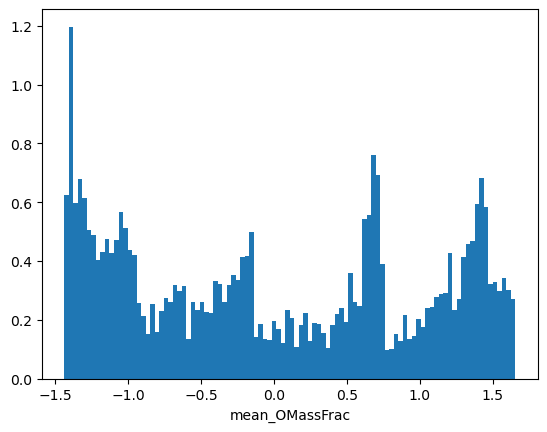

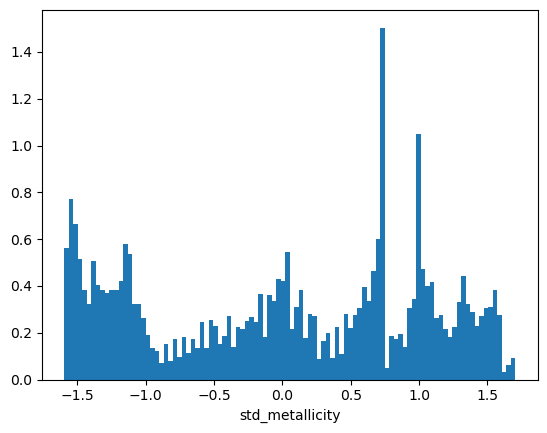

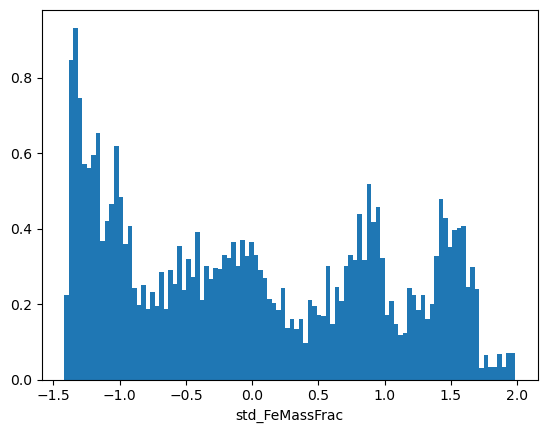

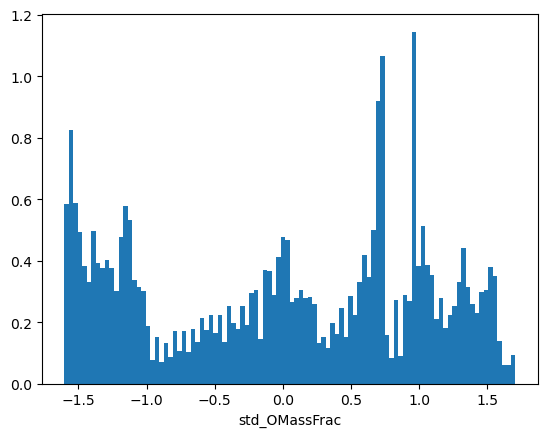

In [22]:
for i in range(len(a.keys())):
    plt.hist(a.values[:,i], bins=100, density=True)
    plt.xlabel(f'{a.keys()[i]}')
    plt.show();

In [23]:
a.dm_mass

0            0.123854
1            0.123854
2            0.123854
3            0.123854
4            0.123854
               ...   
880879571    0.123852
880879572    0.123852
880879573    0.123852
880879574    0.123852
880879575    0.123852
Name: dm_mass, Length: 880879576, dtype: float64